### Co-authored by Martin Beck, Yeggi Lee, Tanvi Modi, Sasha Opela, Jackson Ross, Matt Zlotnik as a result of our Business Data Science final project.

Based on Data set from UCI's Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Reading Data

In [3]:
# Reading shopping data
X_train = pd.read_csv('ShoppingData.csv')
df = X_train.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

## Producing dummy variables for categorical data and cleaning data

In [5]:
dummiesdf = pd.get_dummies(df['VisitorType'])
df.drop('VisitorType', inplace = True, axis = 1)
df['New_Visitor'] = dummiesdf['New_Visitor']
df['Other'] = dummiesdf['Other']
df['Returning_Visitor'] = dummiesdf['Returning_Visitor']

In [6]:
dummiesdf.head()

,New_Visitor,Other,Returning_Visitor
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [7]:
dfmonth = pd.get_dummies(df['Month']) 
df.drop('Month', inplace = True, axis = 1)
dfwithdummies = pd.concat([df, dfmonth], axis = 1, sort = False)

In [8]:
dfwithdummies['Class'] = df['Revenue'].astype(int)
dfwithdummies.drop('Revenue', axis = 1, inplace = True)
dfwithdummies['Weekend'] = df['Weekend'].astype(int)
dfwithdummies.drop('Returning_Visitor', axis = 1, inplace = True)
dfcleaned = dfwithdummies.copy()

In [9]:
X = dfcleaned.drop('Class', axis = 1)
Y = dfcleaned['Class'].copy()

## Checking for Collinearity Between Features and Creating Reducing Feature Size

In [10]:
cor = X.corr()

<AxesSubplot:>

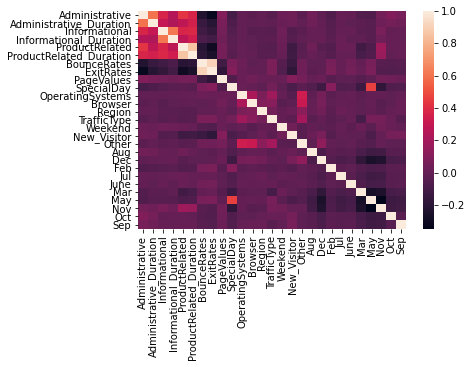

In [11]:
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

In [12]:
# dfcleaned[dfcleaned['New_Visitor'] == 1]['Administrative'].value_counts()
def AvgMinutes(Count, Duration):
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output
    
Columns = [['Administrative', 'Administrative_Duration'], ['Informational', 'Informational_Duration'], ['ProductRelated', 'ProductRelated_Duration']]
    
    
X['AvgAdministrative'] = X.apply(lambda x: AvgMinutes(Count = x['Administrative'], Duration = x['Administrative_Duration']), axis = 1)
X['AvgInformational'] = X.apply(lambda x: AvgMinutes(Count = x['Informational'], Duration = x['Informational_Duration']), axis = 1)
X['AvgProductRelated'] = X.apply(lambda x: AvgMinutes(Count = x['ProductRelated'], Duration = x['ProductRelated_Duration']), axis = 1)
X.drop(['Administrative', 'Administrative_Duration','Informational', 'Informational_Duration','ProductRelated', 'ProductRelated_Duration'], axis = 1, inplace = True)

<AxesSubplot:>

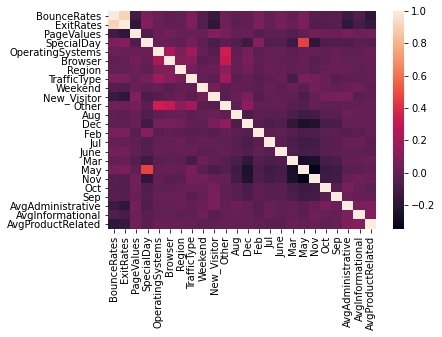

In [13]:
cor = X.corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

## Quick overview of features

<Figure size 432x288 with 0 Axes>

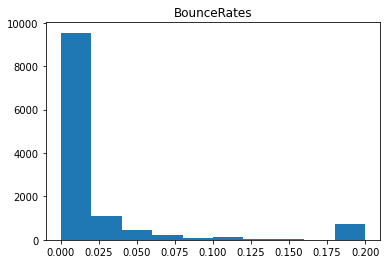

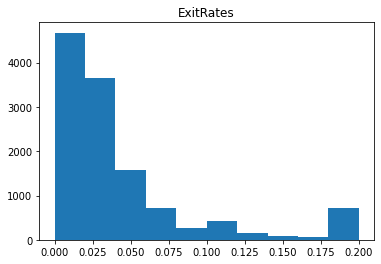

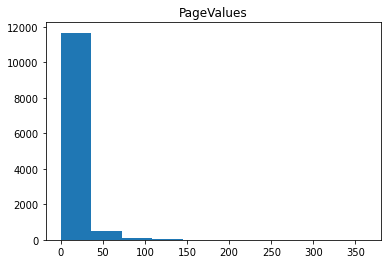

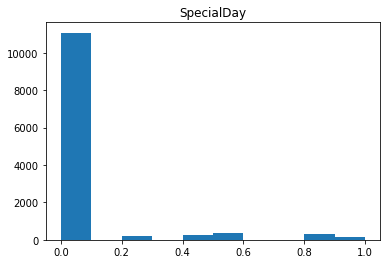

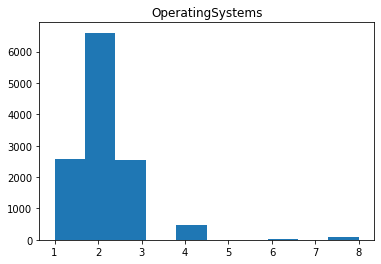

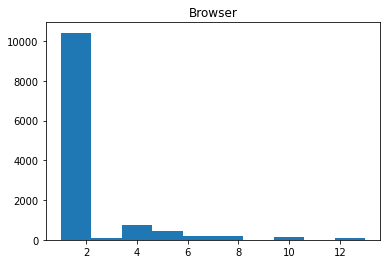

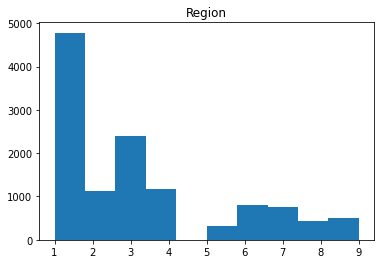

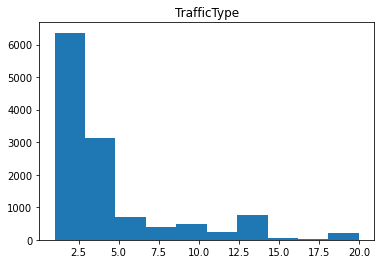

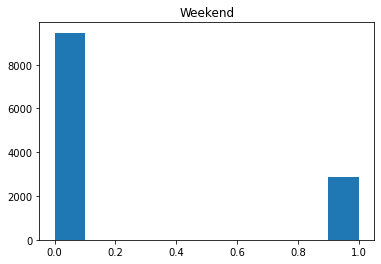

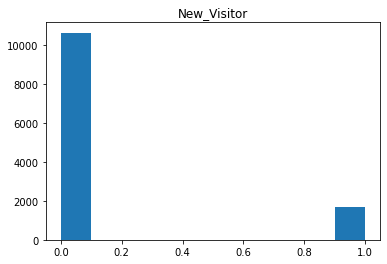

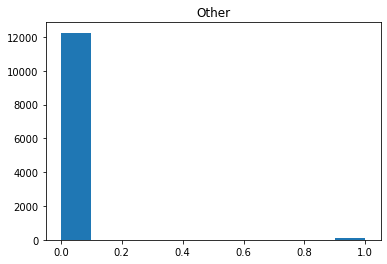

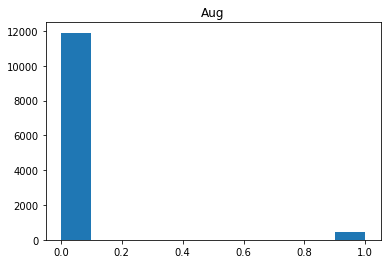

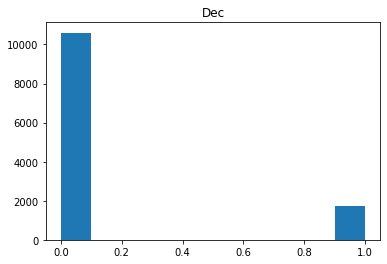

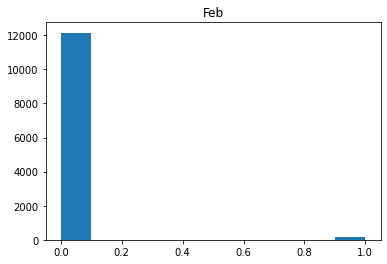

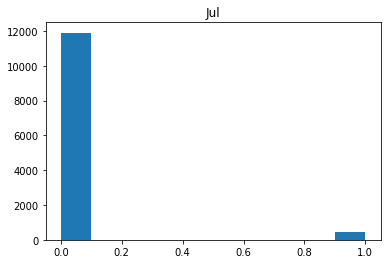

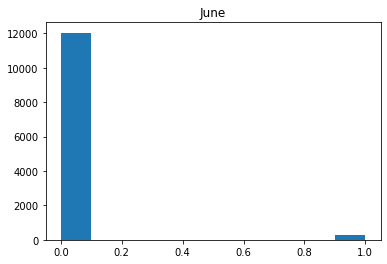

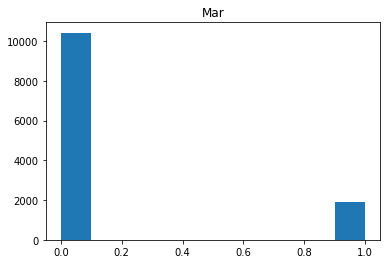

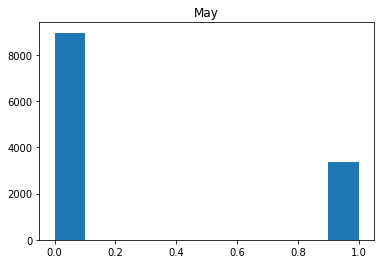

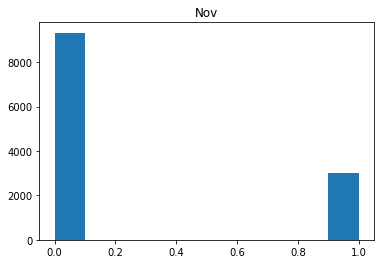

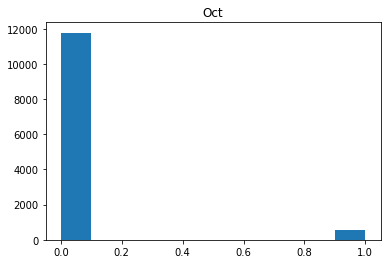

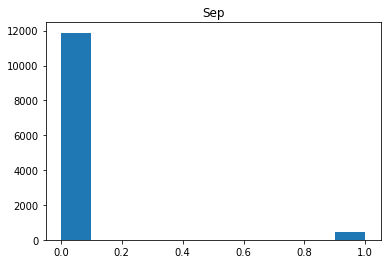

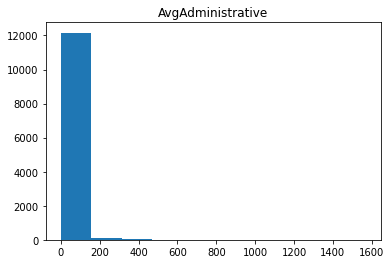

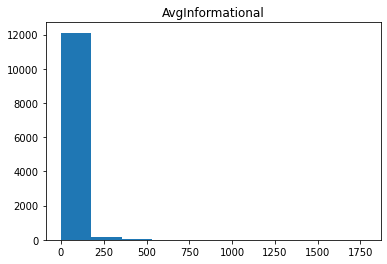

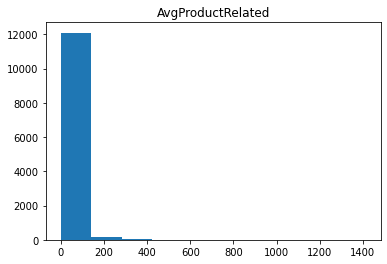

In [14]:
# Histogram of all features
for idx,column in enumerate(X.columns): 
    plt.figure(idx)
    X.hist(column=column,grid=False)

In [15]:
# Checking for NA values
for i in X.columns:
    print('Feature:',i)
    print('# of N/A:',X[i].isna().sum())

Feature: BounceRates
# of N/A: 0
Feature: ExitRates
# of N/A: 0
Feature: PageValues
# of N/A: 0
Feature: SpecialDay
# of N/A: 0
Feature: OperatingSystems
# of N/A: 0
Feature: Browser
# of N/A: 0
Feature: Region
# of N/A: 0
Feature: TrafficType
# of N/A: 0
Feature: Weekend
# of N/A: 0
Feature: New_Visitor
# of N/A: 0
Feature: Other
# of N/A: 0
Feature: Aug
# of N/A: 0
Feature: Dec
# of N/A: 0
Feature: Feb
# of N/A: 0
Feature: Jul
# of N/A: 0
Feature: June
# of N/A: 0
Feature: Mar
# of N/A: 0
Feature: May
# of N/A: 0
Feature: Nov
# of N/A: 0
Feature: Oct
# of N/A: 0
Feature: Sep
# of N/A: 0
Feature: AvgAdministrative
# of N/A: 0
Feature: AvgInformational
# of N/A: 0
Feature: AvgProductRelated
# of N/A: 0


In [16]:
for i in X_train.columns:
    print('####################')
    print('COLUMN TITLE:',i)
    print('# UNIQUE VALUES:',len(X_train[i].unique()))
    print('UNIQUE VALUES:',X_train[i].unique())
    print('####################')
    print()

####################
COLUMN TITLE: Administrative
# UNIQUE VALUES: 27
UNIQUE VALUES: [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26]
####################

####################
COLUMN TITLE: Administrative_Duration
# UNIQUE VALUES: 3335
UNIQUE VALUES: [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]
####################

####################
COLUMN TITLE: Informational
# UNIQUE VALUES: 17
UNIQUE VALUES: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]
####################

####################
COLUMN TITLE: Informational_Duration
# UNIQUE VALUES: 1258
UNIQUE VALUES: [  0.   120.    16.   ... 547.75 368.25 211.25]
####################

####################
COLUMN TITLE: ProductRelated
# UNIQUE VALUES: 311
UNIQUE VALUES: [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29

<Figure size 432x288 with 0 Axes>

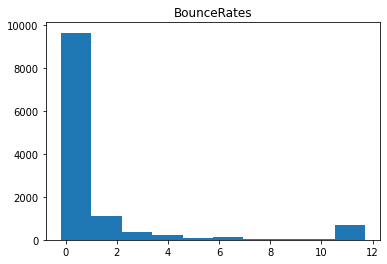

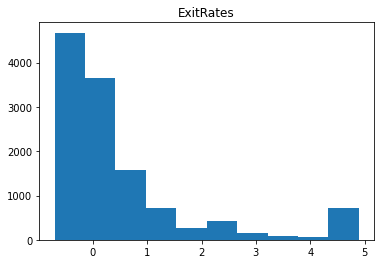

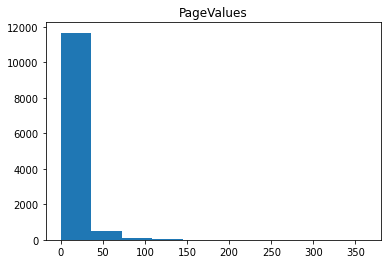

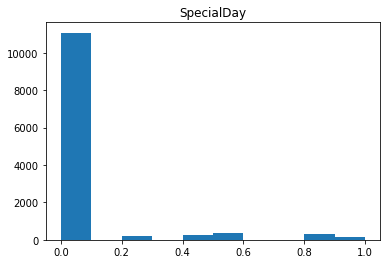

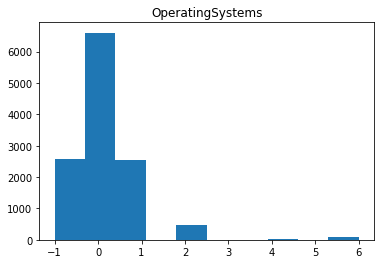

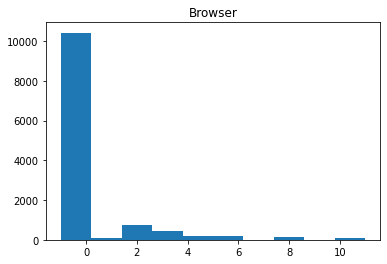

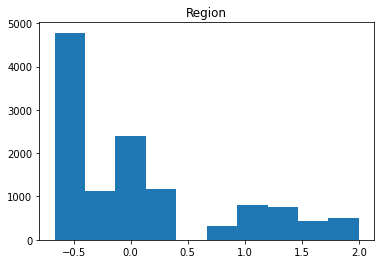

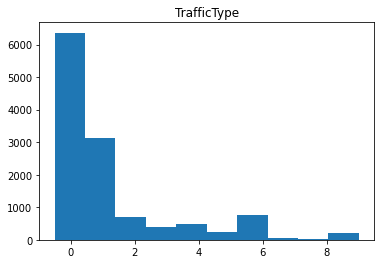

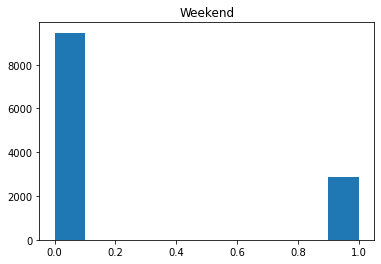

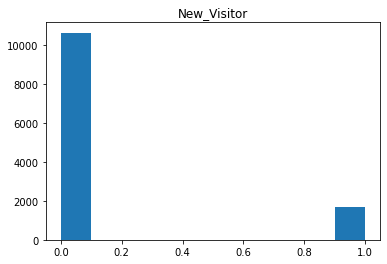

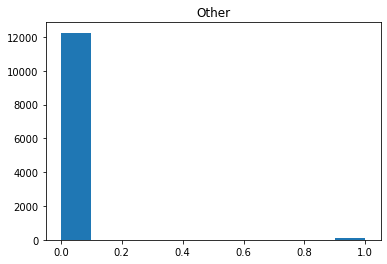

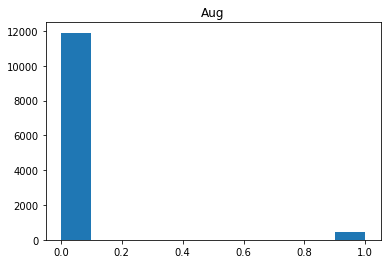

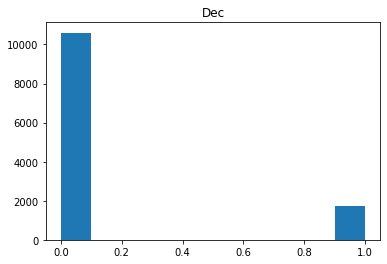

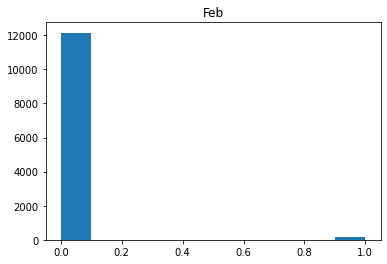

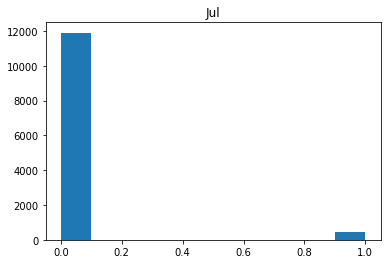

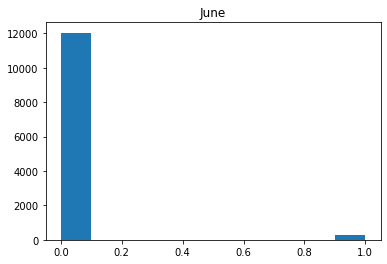

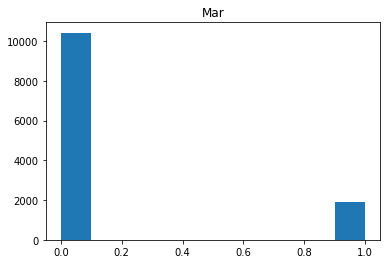

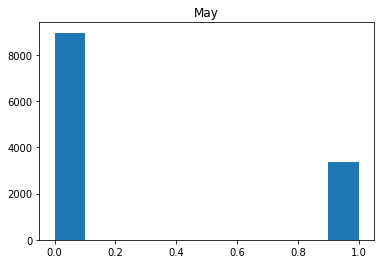

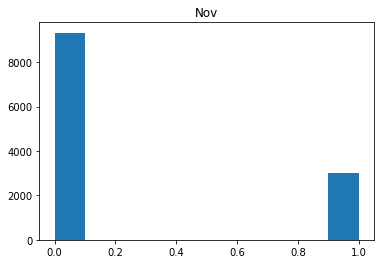

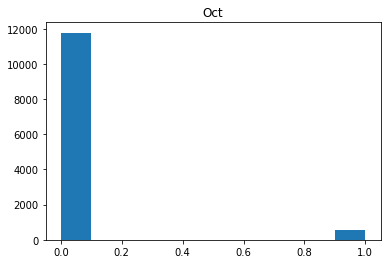

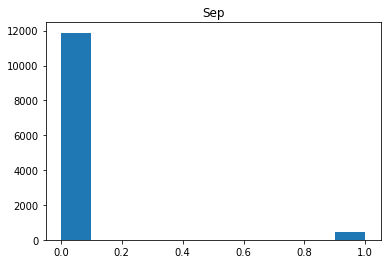

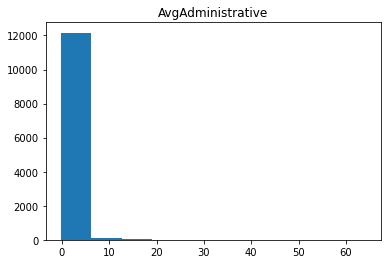

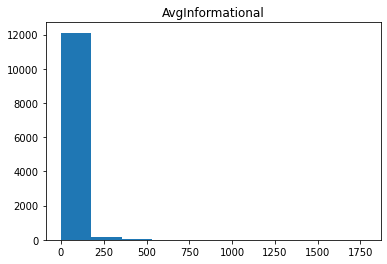

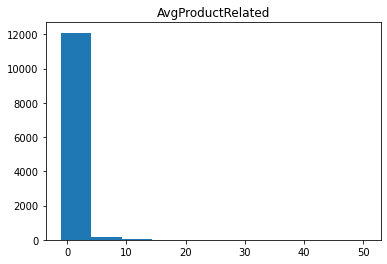

In [17]:
# Scaling to normalize data
X_copy = X.copy()
rc = RobustScaler()
X_rc=rc.fit_transform(X_copy)
X_rc=pd.DataFrame(X_rc,columns=X.columns)

for idx,column in enumerate(X_rc.columns):
    plt.figure(idx)
    X_rc.hist(column=column,grid=False)

## Linear Model with All Features

In [18]:
from sklearn import linear_model
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X_rc,Y,test_size=.2)

In [19]:
# Linear model
model = linear_model.SGDClassifier()
model.fit(X_train, y_train)

SGDClassifier()

In [20]:
y_pred = model.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8256285482562855

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8008876135820182

## Random Forest with all Features

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=17, random_state=0)
clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred1)

0.8961881589618816

In [25]:
roc_auc_score(y_test, y_pred1)

0.7429210903873744

## Finding Important Features then Removing from Dataframe

In [26]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

fmt = '%-8s%-20s%s'

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
2,175126.808512,PageValues
22,10662.599140,AvgInformational
21,6829.412944,AvgAdministrative
23,1143.263922,AvgProductRelated
18,223.548231,Nov
9,115.339482,New_Visitor
17,54.997108,May
3,53.797094,SpecialDay
16,42.613274,Mar
0,29.654336,BounceRates


In [27]:
X_rc.drop(['Aug','TrafficType','OperatingSystems','Other','Jul'],axis=1,inplace=True)

In [28]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_rc,Y,test_size=.2)

## Random Forest Classifier with Feature Selection Dataframe

In [29]:
clf1 = RandomForestClassifier(n_estimators= 200, max_depth = 30 )
clf1.fit(X_train1, y_train1)
y_pred2 = clf1.predict(X_test1)

In [30]:
accuracy_score(y_test1, y_pred2)

0.9091646390916464

In [31]:
roc_auc_score(y_test1, y_pred2)

0.7690455017044612

## XGBoost Classifier with Feature Selection Dataframe

In [32]:
model = XGBClassifier(learning_rate = 0.1, n_estimators=150, min_child_weight=3,  max_depth=13)
model.fit(X_train1, y_train1)

[17:48:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
y_pred3 = model.predict(X_test1)

In [34]:
accuracy_score(y_test1, y_pred3)

0.9091646390916464

In [35]:
roc_auc_score(y_test1, y_pred3)

0.7742515191937157

In [36]:
X_train = pd.read_csv('ShoppingData.csv')

In [37]:
X_train['Class'] = X_train['Revenue'].astype(int)
X_train['Weekend'] = X_train['Weekend'].astype(int)
X_train = X_train.drop('Revenue', axis = 1)
Y_train = X_train['Class'].copy()
X_train = X_train.drop('Class', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=.1)

In [38]:
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
11749,0,0.0,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.0,Nov,1,8,3,1,Returning_Visitor,1
2364,0,0.0,0,0.0,5,214.000000,0.000000,0.040000,0.000000,0.0,May,3,2,8,1,Returning_Visitor,0
3877,0,0.0,0,0.0,12,590.833333,0.010000,0.030000,0.000000,0.0,May,1,1,6,4,Returning_Visitor,0
7081,2,60.5,0,0.0,26,1145.170000,0.000000,0.003704,0.000000,0.0,Nov,1,1,2,2,New_Visitor,1
4869,4,46.4,0,0.0,128,5287.233333,0.017188,0.034483,14.984875,0.4,May,2,2,3,13,Returning_Visitor,0


In [39]:
categorial_variables = []
for i in zip(X_train.columns, X_train.dtypes):
    if i[1] == object:
        categorial_variables.append(i[0])
        print(*i)
categorial_variables

Month object
VisitorType object


['Month', 'VisitorType']

In [40]:
for i in zip(X_train.columns, X_train.dtypes):
    print(*i)

Administrative int64
Administrative_Duration float64
Informational int64
Informational_Duration float64
ProductRelated int64
ProductRelated_Duration float64
BounceRates float64
ExitRates float64
PageValues float64
SpecialDay float64
Month object
OperatingSystems int64
Browser int64
Region int64
TrafficType int64
VisitorType object
Weekend int64


In [41]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import TransformerMixin, BaseEstimator


def AvgMinutes(Count, Duration):
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output
    
Columns = ['Administrative', 'Administrative_Duration',
           'Informational', 'Informational_Duration',
           'ProductRelated', 'ProductRelated_Duration']

class CustomTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['AvgAdministrative'] = X.apply(lambda x: AvgMinutes(Count = x['Administrative'], Duration = x['Administrative_Duration']), axis = 1)
        X['AvgInformational'] = X.apply(lambda x: AvgMinutes(Count = x['Informational'], Duration = x['Informational_Duration']), axis = 1)
        X['AvgProductRelated'] = X.apply(lambda x: AvgMinutes(Count = x['ProductRelated'], Duration = x['ProductRelated_Duration']), axis = 1)
        X.drop(['Administrative', 'Administrative_Duration','Informational', 'Informational_Duration','ProductRelated', 'ProductRelated_Duration'], axis = 1, inplace = True)
        return X[['AvgAdministrative', 'AvgInformational', 'AvgProductRelated']]

feature_engineering = make_pipeline(
    ColumnTransformer([
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorial_variables),
        ('Avg', CustomTransform(), Columns),
    ], remainder='passthrough')
)

In [42]:
foo = feature_engineering.fit_transform(X_train)

In [43]:
X_train.shape, foo.shape

((11097, 17), (11097, 25))

In [50]:
from sklearn.feature_selection import SelectFwe, f_classif

main_pipeline = make_pipeline(
    feature_engineering,
    RobustScaler(),
    SelectFwe(score_func=f_classif, alpha=0.027),
    XGBClassifier(learning_rate = 0.1, n_estimators=150, min_child_weight=3,  max_depth=13, use_label_encoder=False)
)
model = main_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

[17:50:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7751934186094492

In [51]:
foo = X_test.iloc[[138]]
model.predict(foo)

array([0])

In [52]:
import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']